## Exploring Malaria Simulation Output Data

In [ ]:
from src.analysis import *

strategies = [
    "AL5",
    "AL4",
    "AL25-ASAQ75",
    "AL25-DHAPPQ75",
    "AL50-ASAQ50",
    "AL50-DHAPPQ50",
    "AL75-ASAQ25",
    "AL75-DHAPPQ25",
    "ASAQ",
    "ASAQ25-DHAPPQ75",
    "ASAQ50-DHAPPQ50",
    "ASAQ75-DHAPPQ25",
    "DHA-PPQ",
    "status_quo",
    "DHA-PPQ_3yrs_then_5day_AL50-ASAQ50",
    "DHA-PPQ_3yrs_then_AL50-DHAPPQ50",
]

In [ ]:
import os
import glob

# DATA_ROOT: str = os.path.join("G:\\", "My Drive")
DATA_ROOT: str = os.path.join("/", "home", "james", "Code", "Temple-Malaria-Simulation-Analysis")
# DATA_SOURCE: str = os.path.join(DATA_ROOT, "Code", "output_old")
DATA_SOURCE: str = os.path.join(DATA_ROOT, "output2", "rwa")
filelist = glob.glob(os.path.join(DATA_SOURCE, "*.db"))

Prefilter the data to clear out runs that didn't complete

In [ ]:
import shutil

for file in filelist:
    months = get_table(file, "monthlydata")
    try:
        last_month = months["id"].to_list()[-1]
    except IndexError:
        print(f"File: {file} is missing data")
        continue
    if last_month < 385:
        print(f"File: {file} is missing data for month {last_month}")
        continue
    # move the file to the correct location
    shutil.move(file, os.path.join("good", os.path.basename(file)))

In [ ]:
# Create treatment failure plots for all strategies
# Note: due to incomplete batch runs, some strategies may not have data or have incomplete data
# Incomplete data will result in a ValueError when plotting due to a dimension mismatch

DATA_SOURCE: str = os.path.join(DATA_ROOT, "good")

for strategy in strategies:
    try:
        data = aggregate_failure_rates(DATA_SOURCE, strategy)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    if data is None:
        print(f"No data found for {strategy} or there was an aggregation error")
        continue
    try:
        fig, ax = plot_strategy_treatment_failure(data, strategy.replace("_", " ").title())
    except ValueError as e:
        print(e)
        plt.close(fig)
        continue
    plt.savefig(f"{strategy}.png")
    plt.close(fig)

In [ ]:
# Create a violin plot for a given genotype based on the row in agg_fqy
fig, ax = plt.subplots()
locationid = 1
for i, strategy in enumerate(strategies):
    try:
        agg_fqy = aggregate_resistant_genome_frequencies(DATA_SOURCE, strategy, "H", 325, locationid)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    except ValueError as e:
        print(e)
        continue
    except IndexError as e:
        print(e)
        continue
    try:
        ax.violinplot(agg_fqy, positions=[i], showmeans=True, orientation="horizontal")
    except Exception as e:
        print(e)
        print(f"Error plotting {strategy}")
        continue
title = "Genotype Frequencies"  # for Location {locationid}"
if locationid > 0:
    title += f" for Location {locationid}"
ax.set_title(title)
ax.set_xlabel("Frequency")
ax.set_ylabel("Strategy")
ax.set_yticks(range(len(strategies)))
ax.set_yticklabels(strategies)
plt.savefig("genotype_frequencies_violins.png")
plt.show()

Next we want to create Figure 2 from the [zubpko23 paper](https://mol.ax/pdf/zupko23b.pdf). Rather, than compare treatments, let's just do the results for one treatment per plot. 

Plot the following:
1. Number of treamtment failures plus 90% confidence interval
2. Resistant genometypes plus 90% confidence interval
3. PfPR2-10 (twelve month smoothed malaria prevelance in children 2-10 years old)

Plots are over ten years from when the treatment was started.

In [ ]:
for strategy in strategies:
    try:
        fig = plot_combined_strategy_aggragated_results(DATA_SOURCE, strategy, "H", 1)
    except Exception as e:
        print(e)
        continue
    plt.savefig(f"{strategy}_combined.png")
    plt.show()
    plt.close(fig)

In [6]:
import numpy as np


def read_raster(file: str) -> np.ndarray:
    with open(file, "r") as f:
        data = f.read().splitlines()
    metadata = data[:6]
    data = data[6:]
    # convert the metadata to a dictionary
    metadata = {line.split()[0]: float(line.split()[1]) for line in metadata}
    raster = np.zeros((int(metadata["nrows"]), int(metadata["ncols"])))
    for i, line in enumerate(data):
        # for j, char in enumerate(line):
        #    raster[i, j] = float(char)
        line = line.split()
        line = np.asarray(line, dtype=float)
        raster[i, :] = line
    # filter metadata['NODATA_value'] from the raster to be np.nan
    raster[raster == metadata["NODATA_value"]] = np.nan
    return raster, metadata

In [7]:
districts, _ = read_raster("data/moz/moz_districts.asc")
population, _ = read_raster("data/moz/moz_population.asc")
prevalence, _ = read_raster("data/moz/moz_pfpr210.asc")
treatment, _ = read_raster("data/moz/moz_treatmentseeking.asc")

In [14]:
population.size - np.isnan(population).sum()

np.int64(32011)

In [10]:
over50k = population[population > 50000]

In [17]:
np.sum(over50k)

np.float64(4083116.0)

In [12]:
over50k.shape

(35,)

In [1]:
import pandas as pd

district_names = pd.read_csv("data/moz/moz_mapping.csv", index_col="ID")
names = district_names.to_dict()["DISTRICT"]

In [2]:
names

{1: 'Cabo_Delgado',
 2: 'Gaza',
 3: 'Inhambane',
 4: 'Manica',
 5: 'Maputo',
 6: 'Maputo_City',
 7: 'Nampula',
 8: 'Niassa',
 9: 'Sofala',
 10: 'Tete',
 11: 'Zambezia'}

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## Districts

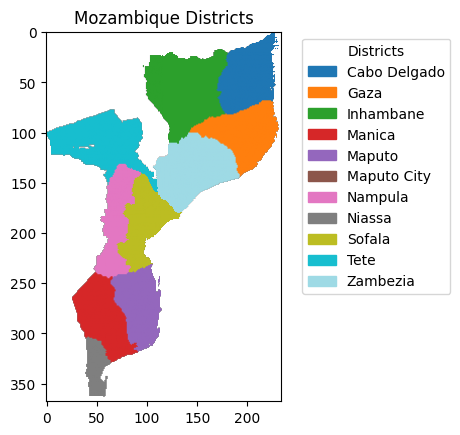

In [52]:
# define a custom color map for the 11 districts
cmap = plt.get_cmap("tab20", 11)
# create a new figure
fig, ax = plt.subplots()
# plot the districts raster
ax.imshow(districts, cmap=cmap)
ax.set_title("Mozambique Districts")

# create legend handles
handles = [Patch(color=cmap(i), label=names[i + 1].replace("_", " ")) for i in range(11)]
ax.legend(bbox_to_anchor=(1.75, 1), handles=handles, title="Districts", loc="upper right")

plt.show()

## Population

In [9]:
np.nanmax(population)

np.float64(358023.0)

In [16]:
np.nansum(population)

np.float64(31302328.0)

In [15]:
np.sum(population)

np.float64(nan)

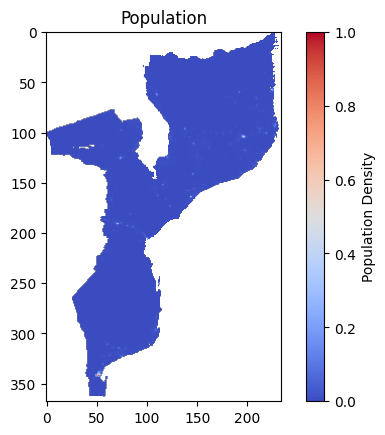

In [79]:
fig, ax = plt.subplots()
ax.imshow(population, cmap="coolwarm")
ax.set_title("Population")
fig.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax, label="Population Density")
plt.show()

## Prevalence

This is what we'll end up calibrating too.

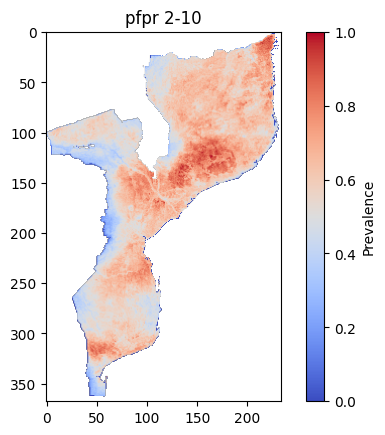

In [72]:
fig, ax = plt.subplots()
ax.imshow(prevalence, cmap="coolwarm")
ax.set_title("pfpr 2-10")
fig.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax, label="Prevalence")
plt.show()

## YAML experimentation

In [1]:
from ruamel.yaml import YAML

In [6]:
with open("./templates/raster_db.yml", "r") as f:
    yaml = YAML()
    config = yaml.load(f)

In [4]:
with open("out.yml", "w") as f:
    yaml.dump(config, f)

In [7]:
config

{'raster_db': {'population_raster': '#POPULATION#.asc', 'ecoclimatic_raster': '#ZONE#.asc', 'beta_by_location': ['$BETA$'], 'cell_size': 5, 'age_distribution_by_location': [[0.0449, 0.0449, 0.0449, 0.0449, 0.0315, 0.0315, 0.0315, 0.0315, 0.0315, 0.0268, 0.0268, 0.0268, 0.0268, 0.0268, 0.199, 0.1251, 0.0855, 0.056, 0.0346, 0.0289, 0.0]], 'p_treatment_for_less_than_5_by_location': ['$ACCESSU5$'], 'p_treatment_for_more_than_5_by_location': ['$ACCESSO5$']}}

In [9]:
1826 / 365.25

4.999315537303217

In [ ]:
5 * 365.25

1826.25